# Processing Images using Workflows
Here we will take a look at how we can apply a workflow to a dask stack. This allows us to have the best of two worlds:
- Interative workflow development in napari
- Fast and parallel processing in dask

As always we will need to load our images first:

In [1]:
import dask.array as da
from napari_workflows._io_yaml_v1 import load_workflow
import pyclesperanto_prototype as cle

cle.select_device("GTX")

zarr_file = r"C:\Users\ryans\Documents\output data (big)\dask tutorial\lund_zenodo.zarr"
rescaled_stack = da.from_zarr(url=zarr_file, component="rescaled_data")

workflow = load_workflow("lund_labelling2.yaml")
print(workflow)

Workflow:
Result of gaussian_blur (clesperanto) <- (<function gaussian_blur at 0x00000216E2990D30>, 'rescaled_data', None, 1.0, 1.0, 0.0)
Result of top_hat_box (clesperanto) <- (<function top_hat_box at 0x00000216E2A24C10>, 'Result of gaussian_blur (clesperanto)', None, 30.0, 30.0, 0.0)
Result of voronoi_otsu_labeling (clesperanto) <- (<function voronoi_otsu_labeling at 0x00000216E2D78C10>, 'Result of top_hat_box (clesperanto)', None, 1.0, 2.0)



As you can see the workflow contains all functions that we used in napari. To apply this workflow to our images we need to find a way to turn the workflow into a function. This can be done easily for our workflow since we only have one input and one output of the workflow and we can use this function for it:

```python
@dask_clesperanto_adapter
def single_input_single_output_workflow_applier(input_image, workflow):
    from napari_workflows._undo_redo_functionality import copy_workflow_state
    if len(workflow.roots()) != 1 or len(workflow.leafs()) != 1:
        warnings.warn('Workflow Must Have Only 1 Input and 1 Output!')
        return
    new_workflow = copy_workflow_state(workflow)
    new_workflow.set(workflow.roots()[0],input_image)
    
    return np.array(new_workflow.get(workflow.leafs()[0]))
```

Firstly, notice the clesperanto adapter that makes sure that any clesperanto functions in the workflow won't cause any errors. All that the actual function does is set the input_image parameter as the root image of our workflow. Then the last image in the workflow is retrieved. In case any of the images are other array formats than numpy we convert the images to numpy in the last step before returning the result of the workflow.

Let's use this function on one image first to see how it works:

shape: (307, 1024, 512)
dtype: uint32


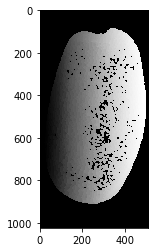

CPU times: total: 8.47 s
Wall time: 29.3 s


In [2]:
%%time
from dask_timelapse_processing_utilities import single_input_single_output_workflow_applier as wf_apply

image = rescaled_stack[0]
test_labels = wf_apply(image, workflow)
print(f"shape: {test_labels.shape}")
print(f"dtype: {test_labels.dtype}")
cle.imshow(test_labels)

That took quite some time, since our image is getting large and we have quite a few operations processing the images. This makes dask a brilliant candidate for processing our whole stack. First we need to map the operation to our whole stack:

In [3]:
labelled_stack = da.map_blocks(
    wf_apply, 
    rescaled_stack, 
    workflow,
    dtype = "uint32",
)
labelled_stack

,Array,Chunk
Bytes,23.98 GiB,614.00 MiB
Shape,"(40, 307, 1024, 512)","(1, 307, 1024, 512)"
Count,81 Tasks,40 Chunks
Type,uint32,numpy.ndarray


Now we can open a client and start the computation by saving the result into our zarr file:

In [4]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=1,threads_per_worker=1,processes=False) 
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://10.2.102.232:8787/status,
Dashboard: http://10.2.102.232:8787/status,Workers: 1
Total threads: 1,Total memory: 23.71 GiB
Status: running,Using processes: False
Comm: inproc://10.2.102.232/2436/1,Workers: 1
Dashboard: http://10.2.102.232:8787/status,Total threads: 1
Started: Just now,Total memory: 23.71 GiB
Comm: inproc://10.2.102.232/2436/4,Total threads: 1
Dashboard: http://10.2.102.232:61888/status,Memory: 23.71 GiB
Nanny: None,


In [5]:
da.to_zarr(
    arr=labelled_stack,
    url = r"C:\Users\ryans\Documents\output data (big)\dask tutorial\lund_zenodo.zarr", 
    component="labelled_data", 
    overwrite=True, 
    compute=True,
    compressor = None
)

In [6]:
client.shutdown()

Now we can look at the results by loading the results from our zarr file and opening it in napari:

In [9]:
import napari

labelled_stack = da.from_zarr(url=zarr_file, component="labelled_data")
labelled_stack

,Array,Chunk
Bytes,23.98 GiB,614.00 MiB
Shape,"(40, 307, 1024, 512)","(1, 307, 1024, 512)"
Count,41 Tasks,40 Chunks
Type,uint32,numpy.ndarray


In [10]:
viewer= napari.Viewer()
viewer.add_image(rescaled_stack)
viewer.add_labels(labelled_stack)

C:\Users\ryans\Anaconda3\envs\np_workflows_v1\envs\dask-testing\lib\site-packages\napari_tools_menu\__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Labels layer 'labelled_stack' at 0x21693b133d0>

INFO:OpenGL.acceleratesupport:No OpenGL_accelerate module loaded: No module named 'OpenGL_accelerate'


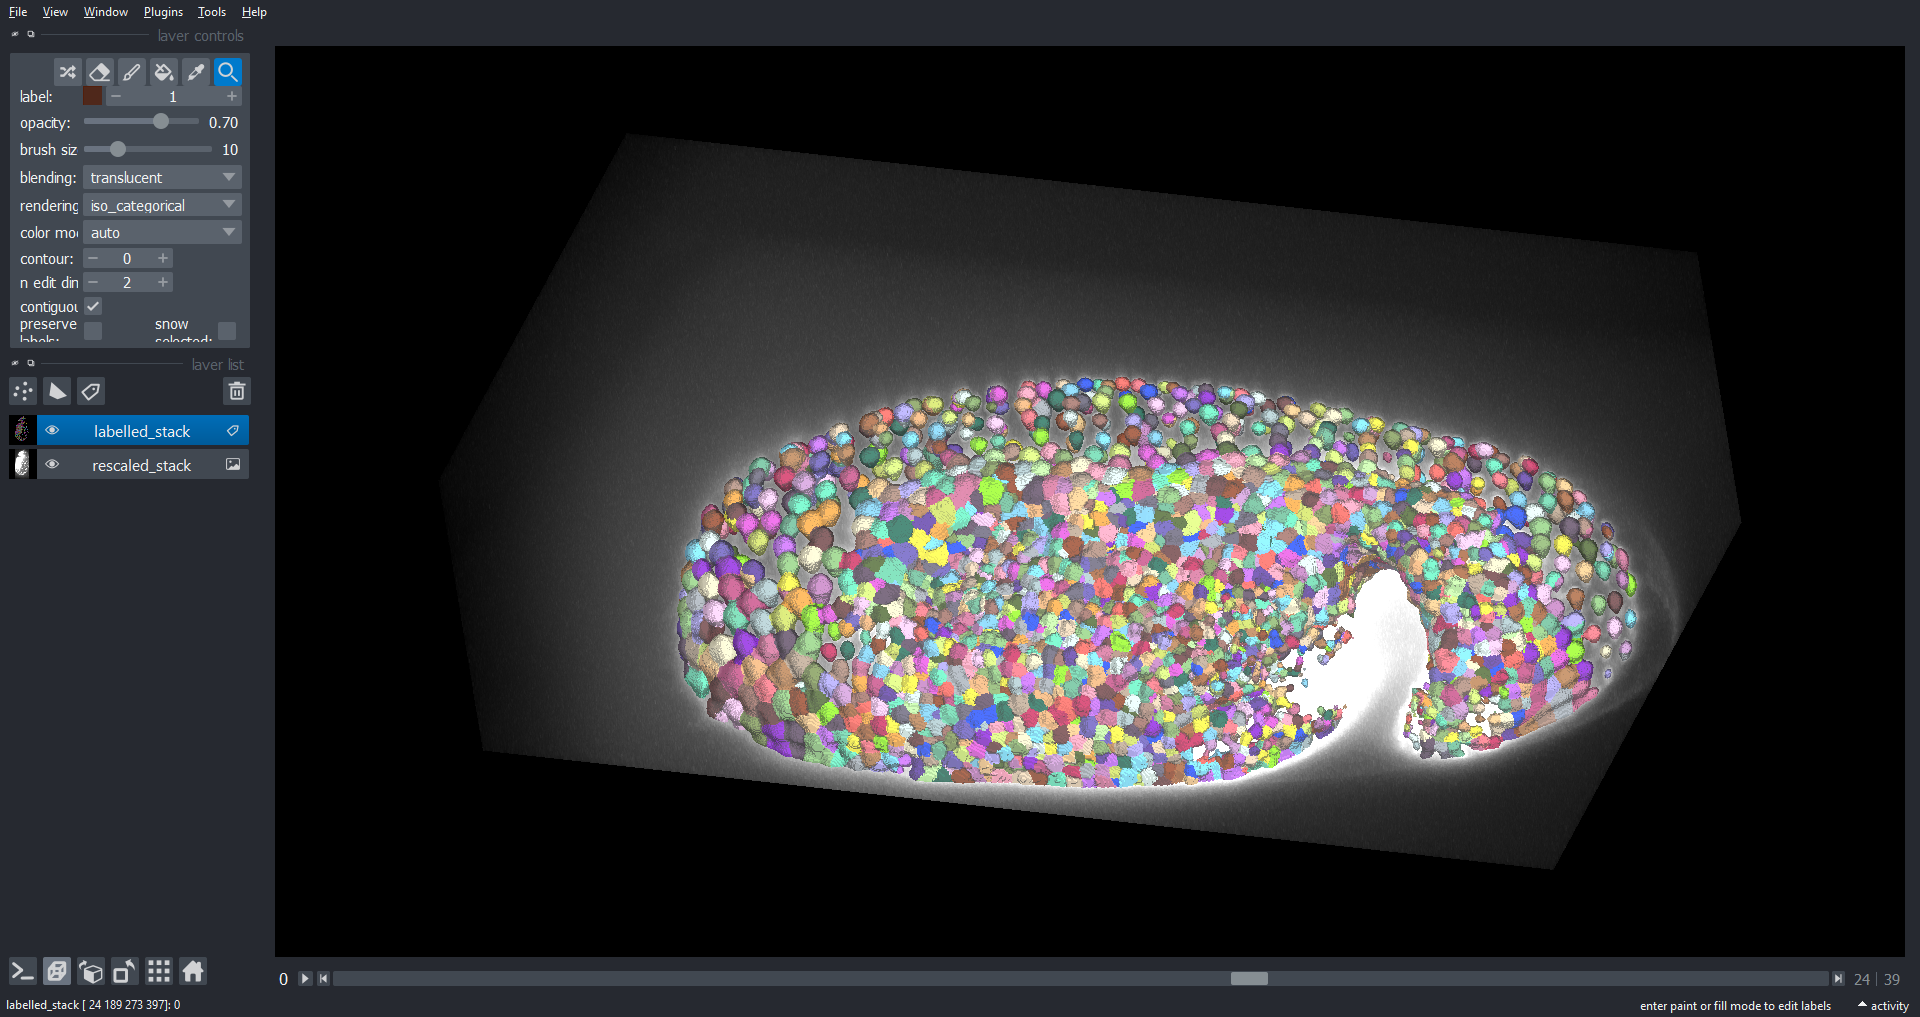

In [11]:
napari.utils.nbscreenshot(viewer)